In [1]:
import pandas as pd
import numpy as np
import pickle
import re

In [30]:
# 2. Carreguem dades
df = pd.read_pickle("data/datosFinal.pkl")

In [ ]:
df

### Preprocessing

1. Company

In [32]:
condicio = (
    df["Company"].str.strip().str.upper().str.endswith("S.L") |
    df["Company"].str.strip().str.upper().str.endswith("SL") |
    df["Company"].str.strip().str.upper().str.endswith("S.L.") |
    df["Company"].str.upper().str.contains("SOCIEDAD LIMITADA")
)

df['es_sociedad_limitada'] = np.where(condicio, 'Sí', 'No')

df.es_sociedad_limitada.value_counts()

es_sociedad_limitada
Sí    544
No     79
Name: count, dtype: int64

2. Names

In [33]:
(df["Company"] == df["Name"]).value_counts()
df = df.drop(columns=["Company"])

3. Investment

In [ ]:
df["Investment"] = (
    df["capital_prev"]
    .astype(str)
    .str.extract(r'([\d.,]+M\s?€)')[0]   # agafa només la part numèrica amb M i €
    .str.replace("€", "", regex=False)
    .str.replace("M", "", regex=False)
    .str.replace("m", "", regex=False)
    .str.replace(",", ".", regex=False)       # canvia coma per punt decimal
    .str.replace(" ", "", regex=False)        # elimina espais
)

# 2. Conversió a numèric (float), posant NaN si hi ha errors
df["Investment"] = pd.to_numeric(df["Investment"], errors="coerce")

# 3. Substitueix 0 per NaN
df["Investment"] = df["Investment"].replace(0.0, np.nan)

# per tenir 0 en comptes de nan
df["Investment"] = df["Investment"].fillna(0)


df.Investment

4. Investor

In [35]:
df.Investors = df.investors
df = df.drop(columns=['investors'])

In [ ]:
all_investors = []

for group in df['Investors'].dropna().tolist():
    splitted = [inv.strip() for inv in group.split(',')]
    all_investors.extend(splitted)

investor_series = pd.Series(all_investors)

# Comptar freqüències
freq_table = investor_series.value_counts().reset_index()

# Renombrar columnes
freq_table.columns = ['Investor', 'Frequency']

# Mostrar la taula
print(freq_table)

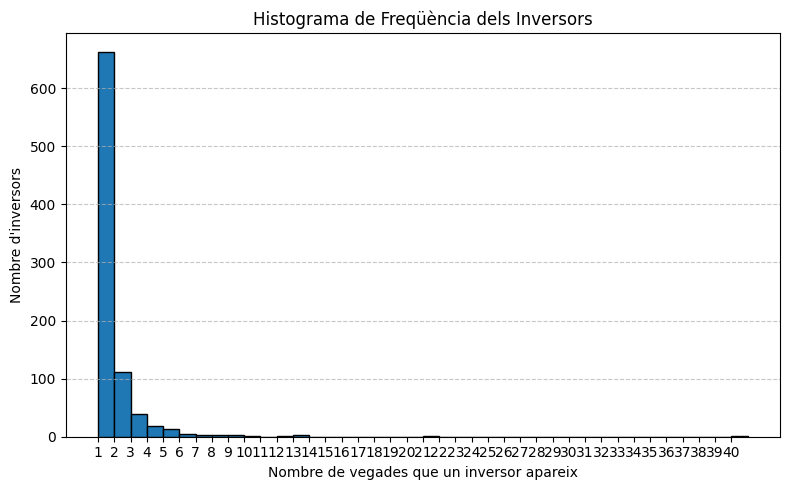

In [8]:
import matplotlib.pyplot as plt

# Suposem que tens aquesta taula:
# freq_table.columns = ['Investor', 'Frequency']

plt.figure(figsize=(8, 5))
plt.hist(freq_table['Frequency'], bins=range(1, freq_table['Frequency'].max() + 2), edgecolor='black')
plt.title('Histograma de Freqüència dels Inversors')
plt.xlabel('Nombre de vegades que un inversor apareix')
plt.ylabel('Nombre d\'inversors')
plt.xticks(range(1, freq_table['Frequency'].max() + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [321]:
#De moment no faig la columna investors perquè hi ha molts pocs que es repeteixen i encara haig de pensar com fer per saber si són persones o no

5. Date

In [37]:
df.Date = df['capital_prev'].str.extract(r'\((.*?)\)')

In [38]:
df = df.drop(columns=['capital_prev'])

In [ ]:
df

In [39]:
df["Mes Inversion"] = [mes.split(" ")[0] for mes in df["Date"]]
df["Year Inversion"] = [mes.split(" ")[1] for mes in df["Date"]]
## Eliminar variable Date

6. Address

Sacamos las coordenadas a partir de la dirección

In [ ]:
df.Address

In [119]:
def limpiar_direccion(dir_raw):
    dir_limpia = dir_raw
    
    # Elimina paréntesis y su contenido
    dir_limpia = re.sub(r"\(.*?\)", "", dir_limpia)
    
    # Elimina referencias tipo P., Pta., Planta, Puerta, Loc, Sector, Sobreático, Num, Tienda
    dir_limpia = re.sub(r"\b(P\. |Pta\.?|Planta|Puerta|Loc|Sector|Sobreático|Num|Tienda)\b\.?\s*\d*\w*", "", dir_limpia, flags=re.IGNORECASE)
    
    # Elimina referencias tipo P., Pta., Planta, Puerta, Loc, Sector, Sobreático, Num, Tienda
    dir_limpia = re.sub(r"C/", "Carrer", dir_limpia, flags=re.IGNORECASE)
    dir_limpia = re.sub(r"Urbanizacion", "Urbanizacio", dir_limpia, flags=re.IGNORECASE)
    dir_limpia = re.sub(r"Rbla", "Rambla", dir_limpia, flags=re.IGNORECASE)
    dir_limpia = re.sub(r"Plaza", "Plaça", dir_limpia, flags=re.IGNORECASE)
    dir_limpia = re.sub(r"Pasaje", "Passatge", dir_limpia, flags=re.IGNORECASE)
    dir_limpia = re.sub(r"Paseig", "Passeig", dir_limpia, flags=re.IGNORECASE)
    
    # Elimina códigos postales (5 dígitos)
    dir_limpia = re.sub(r"\b\d{5}\b", "", dir_limpia)
    
    # Elimina comas innecesarias y múltiples espacios
    dir_limpia = re.sub(r",", "", dir_limpia)
    dir_limpia = re.sub(r"\s+", " ", dir_limpia)
    
    # Limpieza final de espacios
    dir_limpia = dir_limpia.strip()
    
    return dir_limpia

In [120]:
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import time

# Inicializa el geolocalizador
geolocator = Nominatim(user_agent="GetLoc")

# Función segura para geocodificar
def safe_geocode(direccion):
    try:
        location = geolocator.geocode(direccion, timeout=10)
        if location:
            latituds = location.latitude
            longituds = location.longitude
        else:
            print("No se encontró la dirección.")
            latituds = np.nan
            longituds = np.nan
    except GeocoderTimedOut:
        print("Timeout — intentando de nuevo...")
        time.sleep(1)
        return safe_geocode(direccion)
    except Exception as e:
        print("Error:", e)
    return (latituds, longituds)

In [121]:
direcciones = [re.sub("Calle", "Carrer", direc) for direc in df["Address"]]

In [ ]:
direcciones_limpias = [limpiar_direccion(d) for d in direcciones]
direcciones_limpias

In [ ]:
# Llama a la función con tu dirección
latituds = [safe_geocode(dir)[0] for dir in direcciones]


In [ ]:
longituds = [safe_geocode(dir)[1] for dir in direcciones]

In [ ]:
direcciones

In [ ]:
print(pd.DataFrame({'latituds': latituds,'longituds': longituds}).iloc[151:200])

7. Industries

In [40]:
# Elimina salts de línia, tabulacions i espais extra
df['Industries'] = df['Industries'].astype(str) \
    .str.replace(r'[\r\n\t]', '', regex=True) \
    .str.replace(r'\s{2,}', ' ', regex=True) \
    .str.strip()

In [ ]:
# Inicialitzar llista buida
all_industries = []

# Iterar per cada fila
for item in df['Industries'].dropna():
    industries = [i.strip() for i in item.split(',')]
    all_industries.extend(industries)

industries_series = pd.Series(all_industries)
freq_table = industries_series.value_counts().reset_index()
freq_table.columns = ['Industry', 'Frequency']
Industries = freq_table.Industry
print(freq_table)

#Veiem que només hi ha 24 industries, podem fer columnes binàries per a cada indústria

In [42]:
Ind = df[["Name","Industries"]]
M = pd.DataFrame(columns = [Industries])
for i in range(len(Ind)):
    a = Ind.Industries[i]
    a_clean = [i.strip() for i in a.split(',')]
    binary_vector = [1 if industry in a_clean else 0 for industry in Industries]
    M.loc[i] = binary_vector

In [43]:
M

Industry,Business Services & Software,Healthtech,Financing,E-commerce & Marketplaces,ICT & Mobile,Green & Energytech,Food,Hardware,Sustainable mobility,Traveltech & Leisure,...,Gov tech,Gaming,Fashion & Design,Agriculture,Digital Content & Media,Beauty & Personal care,Adtech,Sports,Legaltech,Musictech
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
619,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
620,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
621,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
df_combinat = pd.concat([Ind, M], axis=1)

In [ ]:
#DF = pd.concat([df, M], axis=1)
#df=DF

#En el cas de voler ajuntar les matrius

8. Technologies

In [15]:
# Elimina salts de línia, tabulacions i espais extra
df['Technologies'] = df['Technologies'].astype(str) \
    .str.replace(r'[\r\n\t]', '', regex=True) \
    .str.replace(r'\s{2,}', ' ', regex=True) \
    .str.strip()
df.Technologies

0                  AI & Big Data, Cloud & Edge Computing
1                  AI & Big Data, Cloud & Edge Computing
2                  AI & Big Data, Cloud & Edge Computing
3                  AI & Big Data, Cloud & Edge Computing
4                  AI & Big Data, Cloud & Edge Computing
                             ...                        
618       AI & Big Data, Digital Health, Medical devices
619       AI & Big Data, Digital Health, Medical devices
620    AI & Big Data, Cybersecurity, Cloud & Edge Com...
621                                         Connectivity
622                                           E-commerce
Name: Technologies, Length: 623, dtype: object

In [16]:
# Inicialitzar llista buida
all_technologies = []

# Iterar per cada fila
for item in df['Technologies'].dropna():
    technologies = [i.strip() for i in item.split(',')]
    all_technologies.extend(technologies)

# Crear una sèrie i taula de freqüències
technologies_series = pd.Series(all_technologies)
tech_freq_table = technologies_series.value_counts().reset_index()
tech_freq_table.columns = ['Technology', 'Frequency']

# Guardem la llista única de tecnologies
Technologies = tech_freq_table.Technology
print(tech_freq_table)

# Ara ja pots fer columnes binàries per cada tecnologia

                                        Technology  Frequency
0                                    AI & Big Data        284
1                                       Automation         89
2                           Cloud & Edge Computing         88
3                                    IoT & Sensors         77
4                                       E-commerce         72
5                                   Digital Health         62
6                                    Biotechnology         56
7                              Fintech & Insurtech         56
8                                     Connectivity         48
9                                   Digital Assets         40
10                                        Foodtech         38
11                           Personalized medicine         38
12                                  DLT/Blockchain         37
13                                 Medical devices         34
14                                      Smart City         28
15      

In [17]:
Tech = df[["Name","Technologies"]]
T = pd.DataFrame(columns = [Technologies])
for i in range(len(Tech)):
    a = Tech.Technologies[i]
    a_clean = [i.strip() for i in a.split(',')]
    binary_vector = [1 if technology in a_clean else 0 for technology in Technologies]
    T.loc[i] = binary_vector

In [20]:
df_combinat = pd.concat([Tech, T], axis=1)

In [ ]:
#DF = pd.concat([df, M], axis=1)
#df=DF

#En el cas de voler ajuntar les matrius

9. Categoria

In [18]:
df = df.drop("Category", axis = 1)

10. Other fields

In [19]:
# Elimina salts de línia, tabulacions i espais extra
df['Other fields'] = df['Other fields'].astype(str) \
    .str.replace(r'[\r\n\t]', '', regex=True) \
    .str.replace(r'\s{2,}', ' ', regex=True) \
    .str.strip()
df["Other fields"]

0                       Scaleup
1                       Scaleup
2                       Scaleup
3                       Scaleup
4                       Scaleup
                 ...           
618                     Scaleup
619                     Scaleup
620    Social Economy, Deeptech
621                           -
622                           -
Name: Other fields, Length: 623, dtype: object

In [ ]:
# Inicialitzar llista buida
all_fields = []

# Iterar per cada fila
for item in df['Other fields'].dropna():
    fields = [i.strip() for i in item.split(',')]
    all_fields.extend(fields)

# Crear una sèrie i taula de freqüències
fields_series = pd.Series(all_fields)
fields_freq_table = fields_series.value_counts().reset_index()
fields_freq_table.columns = ['Field', 'Frequency']

# Guardem la llista única de camps
OtherFields = fields_freq_table.Field
print(fields_freq_table)

In [24]:
OFields = df[["Name","Other fields"]]
OF = pd.DataFrame(columns = [OtherFields])
for i in range(len(OFields)):
    a = OFields["Other fields"][i]
    a_clean = [i.strip() for i in a.split(',')]
    binary_vector = [1 if otherfield in a_clean else 0 for otherfield in OtherFields]
    OF.loc[i] = binary_vector

In [338]:
df_combinat = pd.concat([OFields, OF], axis=1)

In [ ]:
#DF = pd.concat([df, OF], axis=1)
#df=DF

#En el cas de voler ajuntar les matrius

11. Funding stage

In [20]:
#No te sentit aquesta variable ja que ja tenim la quantitat exacte
df = df.drop("Funding stage", axis = 1)

12. Founded

In [ ]:
df["Founded"] = df["Founded"].astype(float)
df_clean = df.dropna(subset=['Founded'])

plt.figure(figsize=(10, 6))
plt.hist(df_clean['Founded'], bins=20, edgecolor='black')
plt.title('Histograma de l\'any de fundació')
plt.xlabel('Any de fundació')
plt.ylabel('Nombre de startups')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

13. Employees

In [27]:
df.Employees.value_counts()

Employees
From 1 to 5      120
From 6 to 10     114
From 11 to 20    111
From 21 to 50    111
Undisclosed       96
More than 50      71
Name: count, dtype: int64

14. Business model

In [22]:
# Elimina salts de línia, tabulacions i espais extra
df['Business model'] = df['Business model'].astype(str) \
    .str.replace(r'[\r\n\t]', '', regex=True) \
    .str.replace(r'\s{2,}', ' ', regex=True) \
    .str.strip()
df["Business model"]

0                                      Saas
1                                      Saas
2                                      Saas
3                                      Saas
4                                      Saas
                       ...                 
618    Saas, Software licence, Subscription
619    Saas, Software licence, Subscription
620                          R+D+I Services
621                                    Saas
622                       Ecommerce & Trade
Name: Business model, Length: 623, dtype: object

In [ ]:
# Inicialitzar llista buida
all_models = []

# Iterar per cada fila
for item in df['Business model'].dropna():
    models = [i.strip() for i in item.split(',')]
    all_models.extend(models)

# Crear una sèrie i taula de freqüències
models_series = pd.Series(all_models)
models_freq_table = models_series.value_counts().reset_index()
models_freq_table.columns = ['Business model', 'Frequency']

# Guardar la llista única de models
BusinessModels = models_freq_table['Business model']

print(models_freq_table)

In [31]:
BModels = df[["Name","Business model"]]
BM = pd.DataFrame(columns = [BusinessModels])
for i in range(len(BModels)):
    a = BModels["Business model"][i]
    a_clean = [i.strip() for i in a.split(',')]
    binary_vector = [1 if businessmodel in a_clean else 0 for businessmodel in BusinessModels]
    BM.loc[i] = binary_vector

In [ ]:
print(models_freq_table)

In [ ]:
sums = BM.sum()
print(sums)

In [ ]:
df_combinat = pd.concat([BModels, BM], axis=1)

In [ ]:
#DF = pd.concat([df, BM], axis=1)
#df=DF

#En el cas de voler ajuntar les matrius

15. Target

In [23]:
df['Target'] = df['Target'].astype(str) \
    .str.replace(r'[\r\n\t]', '', regex=True) \
    .str.replace(r'\s{2,}', ' ', regex=True) \
    .str.strip()
df["Target"]

0                Business
1                Business
2                Business
3                Business
4                Business
              ...        
618    Business, Consumer
619    Business, Consumer
620                     -
621              Business
622    Business, Consumer
Name: Target, Length: 623, dtype: object

In [40]:
# Inicialitzar llista buida
all_targets = []

# Iterar per cada fila
for item in df['Target'].dropna():
    targets = [i.strip() for i in item.split(',')]
    all_targets.extend(targets)

# Crear una sèrie i taula de freqüències
targets_series = pd.Series(all_targets)
targets_freq_table = targets_series.value_counts().reset_index()
targets_freq_table.columns = ['Target', 'Frequency']

# Guardar la llista única de targets
Targets = targets_freq_table['Target']

print(targets_freq_table)

     Target  Frequency
0  Business        379
1  Consumer        206
2         -        171


In [42]:
Targ = df[["Name","Target"]]
Ta = pd.DataFrame(columns = [Targets])
for i in range(len(Targ)):
    a = Targ["Target"][i]
    a_clean = [i.strip() for i in a.split(',')]
    binary_vector = [1 if targets in a_clean else 0 for targets in Targets]
    Ta.loc[i] = binary_vector

In [45]:
df_combinat = pd.concat([Targ, T], axis=1)

In [ ]:
#DF = pd.concat([df, T], axis=1)
#df=DF

#En el cas de voler ajuntar les matrius

16. Spinoff participants

In [24]:
df["Spinoff participants"] = df["Spinoff participants"].fillna("").astype(str) \
    .str.replace(r'\(.*?\)', '', regex=True) \
    .str.replace(r'\n', '', regex=True) \
    .str.replace(r'/', '', regex=True) \
    .str.replace(r'\)', '', regex=True) \
    .str.replace(';', ',', regex=False) \
    .str.replace('Fundació Institut d’Investigació i Innovació Parc Tauli', ',', regex=False) \
    .str.replace(' ,', ',', regex=False) \
    .str.strip()
print(df["Spinoff participants"].iloc[35:45])

35    None  Not a spinoff
36    None  Not a spinoff
37    None  Not a spinoff
38           CERCA Centre
39           CERCA Centre
40           CERCA Centre
41           CERCA Centre
42    None  Not a spinoff
43    None  Not a spinoff
44    None  Not a spinoff
Name: Spinoff participants, dtype: object


In [ ]:
# Inicialitzar llista buida
all_participants = []

# Iterar per cada fila
for item in df['Spinoff participants'].dropna():
    participants = [i.strip() for i in item.split(',')]
    all_participants.extend(participants)

# Crear una sèrie i taula de freqüències
participants_series = pd.Series(all_participants)
participants_freq_table = participants_series.value_counts().reset_index()
participants_freq_table.columns = ['Spinoff Participant', 'Frequency']

#Esborro la fila 9 per un error
participants_freq_table = participants_freq_table.drop(index=9).reset_index(drop=True)

# Guardar la llista única de participants
SpinoffParticipants = participants_freq_table['Spinoff Participant']

# Mostrar la taula de freqüències
print(participants_freq_table)


In [75]:
Spin = df[["Name","Spinoff participants"]]
S = pd.DataFrame(columns = [SpinoffParticipants])
for i in range(len(Spin)):
    a = Spin["Spinoff participants"][i]
    a_clean = [i.strip() for i in a.split(',')]
    binary_vector = [1 if spinoffparticipants in a_clean else 0 for spinoffparticipants in SpinoffParticipants]
    S.loc[i] = binary_vector

In [78]:
df_combinat = pd.concat([Spin, T], axis=1)

In [ ]:
#DF = pd.concat([df, S], axis=1)
#df=DF

#En el cas de voler ajuntar les matrius

17. Quantiat d'inversions previes

In [ ]:
df["Num_Inversio"] = df.groupby("Name").cumcount(ascending=False) + 1
print(df[["Name","Num_Inversio"]].head(15))

Para la variable capita_prev contrastar con las variables Investor y Date si son iguales sino se deberá de trabajar para tener 2 variables independientes. 

In [26]:
df = df.drop(columns=["URL", "Date"])

## Guardamos la base de datos 

In [27]:
df.to_pickle(path="data/datos_preprocesados.pkl")
df.to_csv(path_or_buf="data/datos_preprocesados.csv")